Note: the data used in this project can be downloaded from: https://www.dropbox.com/s/cst9awcjpp08k33/50_categories.tar.gz

## Imports

In [155]:
# array handling
import numpy as np
import pandas as pd

# image manipulation
from skimage.io import imread
from skimage.color import rgb2grey
from skimage import transform, feature

# system interaction
import os
import sys
import pickle as pkl

# iteration tools
from tqdm import tqdm
from itertools import combinations

# machine learning
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, zero_one_loss

# plotting
import matplotlib.pyplot as plt
%matplotlib inline


## Global Variables

In [2]:
base_path = '50_categories/'
labels = np.array(sorted([dr for dr in os.listdir(base_path) if '.DS_Store' not in dr]))

## Explore Data

In [3]:
# find dimensions of all images
im_dims = []
for label in labels:
    print('Processing label: {}'.format(label))
    for fl in [fl for fl in os.listdir(base_path + label) if '.DS_Store' not in fl]:
        im = imread(base_path + label + '/' + fl)
        g = rgb2grey(im)
        im_dims.append(g.shape)
im_dims = np.array(im_dims)

Processing label: airplanes
Processing label: bat
Processing label: bear
Processing label: blimp
Processing label: camel
Processing label: comet
Processing label: conch
Processing label: cormorant
Processing label: crab
Processing label: dog
Processing label: dolphin
Processing label: duck
Processing label: elephant
Processing label: elk
Processing label: frog
Processing label: galaxy
Processing label: giraffe
Processing label: goat
Processing label: goldfish
Processing label: goose
Processing label: gorilla
Processing label: helicopter
Processing label: horse
Processing label: hot-air-balloon
Processing label: hummingbird
Processing label: iguana
Processing label: kangaroo
Processing label: killer-whale
Processing label: leopards
Processing label: llama
Processing label: mars
Processing label: mussels
Processing label: octopus
Processing label: ostrich
Processing label: owl
Processing label: penguin
Processing label: porcupine
Processing label: raccoon
Processing label: saturn
Process

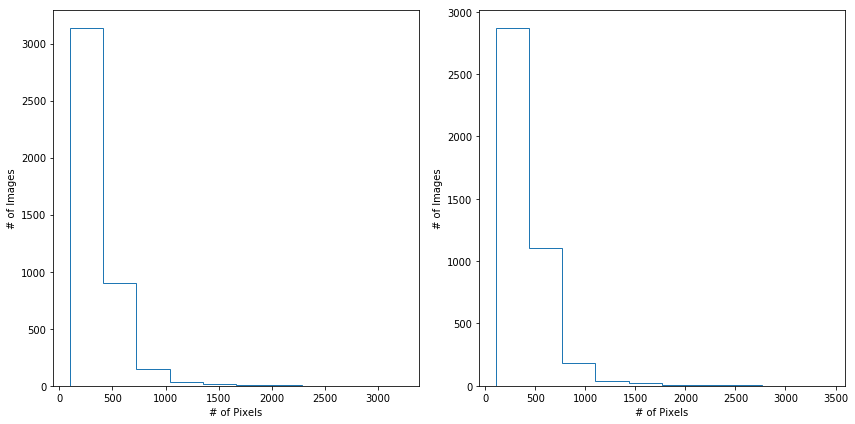

In [4]:
# visualize distribution of dimensions
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].hist(im_dims[:,0], histtype = 'step')
ax[1].hist(im_dims[:,1], histtype = 'step')
for a in ax:
    a.set_ylabel('# of Images')
    a.set_xlabel('# of Pixels')
fig.tight_layout()

Notice that the images are not uniform in size, and also that some are very large. Before doing anything, a sensible preprocessing step is make all images the same size (and smaller). For the purposes of this assignment, we will resize all images to a width of 450 pixels. In a future step we will deal with the fact that the heights will still vary after resizing. Lets write a function to automate the reading of images, conversion to greyscale, and rescaling to 450 pixels in width and then look at the data

In [42]:
def read_grey_rescale(im_file, width = 450):
        im = imread(im_file)
        g = rgb2grey(im)
        r_im = transform.rescale(g, width / g.shape[1], mode = 'constant')
        return r_im

In [6]:
# find dimensions of all images after rescaling
im_dims = []
for label in labels:
    print('Processing label: {}'.format(label))
    for fl in [fl for fl in os.listdir(base_path + label) if '.DS_Store' not in fl]:
        g = read_grey_rescale(base_path + label + '/' + fl)
        im_dims.append(g.shape)
im_dims = np.array(im_dims)

Processing label: airplanes
Processing label: bat
Processing label: bear
Processing label: blimp
Processing label: camel
Processing label: comet
Processing label: conch
Processing label: cormorant
Processing label: crab
Processing label: dog
Processing label: dolphin
Processing label: duck
Processing label: elephant
Processing label: elk
Processing label: frog
Processing label: galaxy
Processing label: giraffe
Processing label: goat
Processing label: goldfish
Processing label: goose
Processing label: gorilla
Processing label: helicopter
Processing label: horse
Processing label: hot-air-balloon
Processing label: hummingbird
Processing label: iguana
Processing label: kangaroo
Processing label: killer-whale
Processing label: leopards
Processing label: llama
Processing label: mars
Processing label: mussels
Processing label: octopus
Processing label: ostrich
Processing label: owl
Processing label: penguin
Processing label: porcupine
Processing label: raccoon
Processing label: saturn
Process

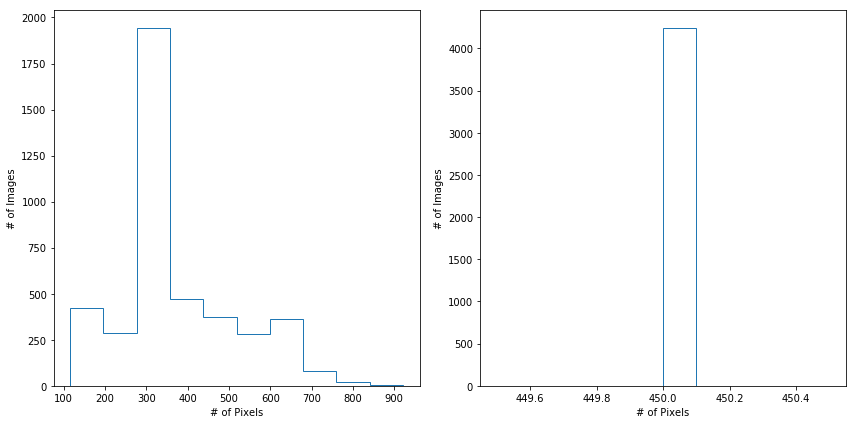

In [7]:
# visualize distribution of dimensions
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].hist(im_dims[:,0], histtype = 'step')
ax[1].hist(im_dims[:,1], histtype = 'step')
for a in ax:
    a.set_ylabel('# of Images')
    a.set_xlabel('# of Pixels')
fig.tight_layout()

We will now deal with the fact that the heights are not identical after scaling all images to the same width. We see from the histogram that majority of images have a height (after rescaling) of around 350 pixels. Our strategy will be to normalize the heights of all images to 400 pixels (to keep a little extra). For images with smaller heights, we will evenly pad above and below with zeros until we reach the appropriate height, and for images with larger heights we will remove an even amount of rows above and below until we reach the appropriate height. Lets write a function to do this.

In [21]:
def trim_pad_height(im_arr, height = 400):
    # create array to hold final image
    new_im = np.zeros((height, im_arr.shape[1]))
    
    # find difference in heights
    h_diff = height - im_arr.shape[0]
    if h_diff % 2 != 0:
        im_arr = im_arr[:-1, :] # cut bottom row of pixels to make the difference even
        h_diff += 1
    
    # now handle the three possibilities for how the heights compare:
    if h_diff == 0:
        new_im = im_arr
    elif h_diff > 0:
        # calculate top and bottom indices
        bottom = int(np.abs((h_diff / 2)))
        top = new_im.shape[0] -  int(np.abs((h_diff / 2)))
        new_im[bottom:top, :] = im_arr
    elif h_diff < 0:
        # calculate top and bottom indices
        bottom = int(np.abs(h_diff / 2)) 
        top = im_arr.shape[0] - int(np.abs(h_diff / 2)) 
        new_im = im_arr[bottom:top, :]
    
    return new_im
    

In [23]:
# one more pass through the images to ensure the rescaling methodology works as expected
im_dims = []
for label in labels:
    print('Processing label: {}'.format(label))
    for fl in [fl for fl in os.listdir(base_path + label) if '.DS_Store' not in fl]:
        g = read_grey_rescale(base_path + label + '/' + fl)
        f = trim_pad_height(g)
        im_dims.append(f.shape)
im_dims = np.array(im_dims)

Processing label: airplanes
Processing label: bat
Processing label: bear
Processing label: blimp
Processing label: camel
Processing label: comet
Processing label: conch
Processing label: cormorant
Processing label: crab
Processing label: dog
Processing label: dolphin
Processing label: duck
Processing label: elephant
Processing label: elk
Processing label: frog
Processing label: galaxy
Processing label: giraffe
Processing label: goat
Processing label: goldfish
Processing label: goose
Processing label: gorilla
Processing label: helicopter
Processing label: horse
Processing label: hot-air-balloon
Processing label: hummingbird
Processing label: iguana
Processing label: kangaroo
Processing label: killer-whale
Processing label: leopards
Processing label: llama
Processing label: mars
Processing label: mussels
Processing label: octopus
Processing label: ostrich
Processing label: owl
Processing label: penguin
Processing label: porcupine
Processing label: raccoon
Processing label: saturn
Process

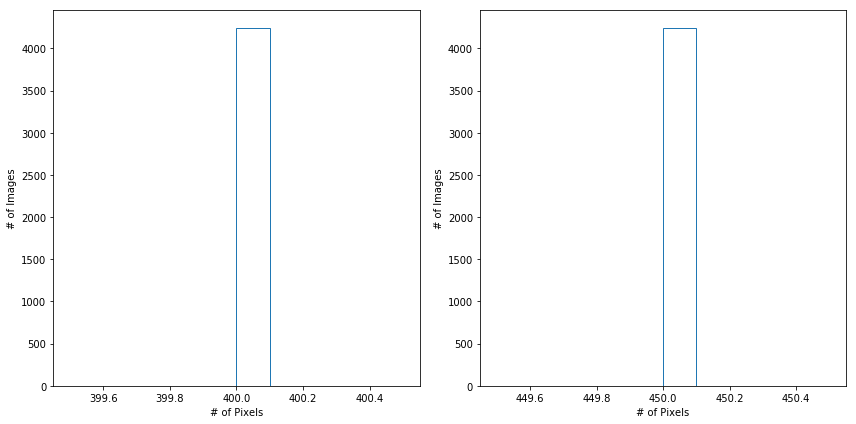

In [24]:
# visualize distribution of dimensions
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].hist(im_dims[:,0], histtype = 'step')
ax[1].hist(im_dims[:,1], histtype = 'step')
for a in ax:
    a.set_ylabel('# of Images')
    a.set_xlabel('# of Pixels')
fig.tight_layout()

This had the expected result, we move on to feature extraction

## Compute Features from Data

In [156]:
# this function will extract "dumb" features that have to do with colors, etc. 
# the features extracted here will inherently be independent of the size of the image array, so we won't worry about resizing for extracting these features
def dumb_feature_extract(img_file):
    
    # read image and get greyscale as well
    im_arr = imread(img_file)
    gi = rgb2grey(im_arr)
    
    # check if image has only one color channel and if so stack the image three times to ensure that there are three
    # (unfortunately) identical color channels
    if len(im_arr.shape) == 2:
        im_arr = np.dstack((im_arr, im_arr, im_arr))
    
    ## instatiate list (later to convert to array) to hold features
    features = []
    
    # calculate the mean in each color
    color_means = im_arr.mean(axis=1).mean(axis=0)
    
    # use the ratio of maximum value in each color to the mean of each color
    color_max_div_mean = im_arr.max(axis=1).max(axis=0) / color_means
    features += list(color_max_div_mean)
     
    # use the ratio of standard deviations in each color to mean in each color as another set of features
    color_std_div_mean = im_arr.std(axis=1).mean(axis=0) / color_means
    features += list(color_std_div_mean)
    
    # use ratios of means, and correlation coefficients between flattened color arrays as additional features
    mean_ratios = []
    corr_coefs = []
    for idx_pair in combinations(range(3), 2):
        mean_ratios.append(color_means[idx_pair[0]] / color_means[idx_pair[1]])
        corr_coefs.append(np.corrcoef(im_arr[:,:,idx_pair[0]].flatten(), im_arr[:,:,idx_pair[1]].flatten())[0,1])
    features += mean_ratios + corr_coefs
    
    return np.array(features)

In [35]:
# get a sense of the time cost of dumb feature extraction

In [36]:
%%timeit
dumb_feature_extract('50_categories/bat/bat_0060.jpg')

11 ms ± 581 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [175]:
# more robust feature extraction using DAISY (similar to SIFT) approach
# inspiration for what I do here comes from: https://github.com/flytxtds/scene-recognition/blob/master/scene_recognition_local_global_approach.ipynb

# basic idea:
#    use DAISY to extract features from each image
#    use a clustering algorithm to map the extracted features from each image into features that are common between all images and (hopefully) describe them - "bag of visual words" concept

In [56]:
# get a sense of the time cost of extracting DAISY features - since need to go through around 4000 images, I am willing to spend at most about 1 second per image (for a little over an hour of computation time)
# note that here we will use resized images

In [86]:
%%timeit
g = read_grey_rescale('50_categories/bat/bat_0060.jpg')
f = trim_pad_height(g)
descs = feature.daisy(f)
descs_num = descs.shape[0] * descs.shape[1]
daisy_descriptors = descs.reshape(descs_num,descs.shape[2])

612 ms ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
# another constraint here is how much RAM is on my laptop, I will need to store a huge list of around 4000 * len(daisy_descriptors). Lets try to estimate this
g = read_grey_rescale('50_categories/bat/bat_0060.jpg')
f = trim_pad_height(g)
descs = feature.daisy(f)
descs_num = descs.shape[0] * descs.shape[1]
daisy_descriptors = descs.reshape(descs_num,descs.shape[2])
sys.getsizeof(list(daisy_descriptors) * 4000) / 1e6 # show in megabytes

# of course the size will be larger due to other overheads, but this looks feasible at the moment.

312.480064

In [88]:
print(daisy_descriptors.shape) # default parameters

(9765, 200)


In [89]:
# note: the above very much underestimates the demands of running this (my swap memory gets SATURATED), so I'm forced to change the parameters of daisy to make things more manageable
descs = feature.daisy(f, step = 10, radius = 25, histograms=6, orientations=6)
descs_num = descs.shape[0] * descs.shape[1]
daisy_descriptors = descs.reshape(descs_num,descs.shape[2])
print(daisy_descriptors.shape)
# lets see if these parameters make the problem doable on my laptop..

(1400, 114)


In [91]:
# create containers to hold the generated data
feature_map = {}
daisy_desc_list = []

# iterate through labels and then through files for each label
for label in labels:
    print('Processing label: {}'.format(label))
    for fl in tqdm([fl for fl in os.listdir(base_path + label) if '.DS_Store' not in fl]): # print status while iterating
        
        # read image and convert to greyscale
        g = read_grey_rescale(base_path + label + '/' + fl)
        f = trim_pad_height(g)
        
        # comptue daisy features
        descs = feature.daisy(f, step = 10, radius = 25, histograms=6, orientations=6)
        descs_num = descs.shape[0] * descs.shape[1]
        daisy_descriptors = descs.reshape(descs_num,descs.shape[2])
        
        # store features
        feature_map[fl] = daisy_descriptors
        daisy_desc_list += list(daisy_descriptors)

  0%|          | 0/533 [00:00<?, ?it/s]

Processing label: airplanes


  0%|          | 0/71 [00:00<?, ?it/s]

Processing label: bat


  0%|          | 0/68 [00:00<?, ?it/s]

Processing label: bear


  0%|          | 0/57 [00:00<?, ?it/s]

Processing label: blimp


  0%|          | 0/73 [00:00<?, ?it/s]

Processing label: camel


  0%|          | 0/81 [00:00<?, ?it/s]

Processing label: comet


  0%|          | 0/69 [00:00<?, ?it/s]

Processing label: conch


  0%|          | 0/71 [00:00<?, ?it/s]

Processing label: cormorant


  0%|          | 0/57 [00:00<?, ?it/s]

Processing label: crab


  0%|          | 0/68 [00:00<?, ?it/s]

Processing label: dog


  0%|          | 0/71 [00:00<?, ?it/s]

Processing label: dolphin


  0%|          | 0/58 [00:00<?, ?it/s]

Processing label: duck


  0%|          | 0/87 [00:00<?, ?it/s]

Processing label: elephant


  0%|          | 0/67 [00:00<?, ?it/s]

Processing label: elk


  0%|          | 0/77 [00:00<?, ?it/s]

Processing label: frog


  0%|          | 0/54 [00:00<?, ?it/s]

Processing label: galaxy


  0%|          | 0/56 [00:00<?, ?it/s]

Processing label: giraffe


  0%|          | 0/75 [00:00<?, ?it/s]

Processing label: goat


  0%|          | 0/62 [00:00<?, ?it/s]

Processing label: goldfish


  0%|          | 0/73 [00:00<?, ?it/s]

Processing label: goose


  0%|          | 0/141 [00:00<?, ?it/s]

Processing label: gorilla


  0%|          | 0/59 [00:00<?, ?it/s]

Processing label: helicopter


  0%|          | 0/180 [00:00<?, ?it/s]

Processing label: horse


  0%|          | 0/59 [00:00<?, ?it/s]

Processing label: hot-air-balloon


  0%|          | 0/77 [00:00<?, ?it/s]

Processing label: hummingbird


  0%|          | 0/71 [00:00<?, ?it/s]

Processing label: iguana


  0%|          | 0/55 [00:00<?, ?it/s]

Processing label: kangaroo


  0%|          | 0/61 [00:00<?, ?it/s]

Processing label: killer-whale


  0%|          | 0/127 [00:00<?, ?it/s]

Processing label: leopards


  0%|          | 0/79 [00:00<?, ?it/s]

Processing label: llama


  0%|          | 0/104 [00:00<?, ?it/s]

Processing label: mars


  0%|          | 0/116 [00:00<?, ?it/s]

Processing label: mussels


  0%|          | 0/74 [00:00<?, ?it/s]

Processing label: octopus


  0%|          | 0/73 [00:00<?, ?it/s]

Processing label: ostrich


  0%|          | 0/80 [00:00<?, ?it/s]

Processing label: owl


  0%|          | 0/99 [00:00<?, ?it/s]

Processing label: penguin


  0%|          | 0/67 [00:00<?, ?it/s]

Processing label: porcupine


  0%|          | 0/93 [00:00<?, ?it/s]

Processing label: raccoon


  0%|          | 0/64 [00:00<?, ?it/s]

Processing label: saturn


  0%|          | 0/54 [00:00<?, ?it/s]

Processing label: skunk


  0%|          | 0/79 [00:00<?, ?it/s]

Processing label: snail


  0%|          | 0/75 [00:00<?, ?it/s]

Processing label: snake


  0%|          | 0/67 [00:00<?, ?it/s]

Processing label: speed-boat


  0%|          | 0/54 [00:00<?, ?it/s]

Processing label: starfish


  0%|          | 0/77 [00:00<?, ?it/s]

Processing label: swan


  0%|          | 0/67 [00:00<?, ?it/s]

Processing label: teddy-bear


  0%|          | 0/72 [00:00<?, ?it/s]

Processing label: toad


  0%|          | 0/63 [00:00<?, ?it/s]

Processing label: triceratops


  0%|          | 0/65 [00:00<?, ?it/s]

Processing label: unicorn


  0%|          | 0/64 [00:00<?, ?it/s]

Processing label: zebra


100%|██████████| 64/64 [00:33<00:00,  1.93it/s]


In [94]:
#feature_map
len(daisy_desc_list)

5941600

In [95]:
sys.getsizeof(daisy_desc_list) / 1e6

47.867512

In [99]:
# do clustering with nc clusters
nc = 150
km = MiniBatchKMeans(n_clusters = nc, batch_size = nc * 10)
km.fit(daisy_desc_list)

MiniBatchKMeans(batch_size=1500, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=150, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [104]:
def extract_daisy_feature_from_image(fname, cluster_model, path = None):
    
    # use the daisy features that have already been computed if possible
    # treats feature_map as a global variable
    if fname in feature_map:
        daisy_features = feature_map[fname]
   
    # otherwise, compute them now
    else:        
        g = read_grey_rescale(path + fname)
        f = trim_pad_height(g)
        
        # compute daisy features
        descs = feature.daisy(f, step = 10, radius = 25, histograms=6, orientations=6)
        descs_num = descs.shape[0] * descs.shape[1]
        daisy_features = descs.reshape(descs_num,descs.shape[2])
        
    # find which clusters each daisy feature belongs to
    img_clusters = cluster_model.predict(daisy_features) 
    cluster_freq_counts = pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    
    # instantiate and then populate an array to hold features
    feats = np.zeros(cluster_model.n_clusters)
    for key in cluster_freq_counts.keys():
        feats[key] = cluster_freq_counts[key]

    # return feature array (normalization will happening later)
    return feats

In [107]:
%%timeit
x = extract_daisy_feature_from_image('bat_0060.jpg', km)

6.4 ms ± 568 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Run Feature Extraction

In [108]:
# process features
X = []
y = []
for label in labels:
    print('Processing label: {}'.format(label))
    for fl in tqdm([fl for fl in os.listdir(base_path + label) if '.DS_Store' not in fl]):
        
        # X array will hold dumb features and daisy features
        X.append(np.concatenate((dumb_feature_extract(base_path + label + '/' + fl), extract_daisy_feature_from_image(fl, km, path = base_path + label + '/'))))
        y.append(label)
        
X = np.array(X)
y = np.array(y)

  0%|          | 2/533 [00:00<00:31, 16.60it/s]

Processing label: airplanes


  1%|▏         | 1/71 [00:00<00:07,  9.13it/s]

Processing label: bat


  0%|          | 0/68 [00:00<?, ?it/s]

Processing label: bear


  5%|▌         | 3/57 [00:00<00:02, 23.28it/s]

Processing label: blimp


  1%|▏         | 1/73 [00:00<00:09,  7.73it/s]

Processing label: camel


  2%|▏         | 2/81 [00:00<00:04, 18.01it/s]

Processing label: comet


  4%|▍         | 3/69 [00:00<00:02, 25.32it/s]

Processing label: conch


  3%|▎         | 2/71 [00:00<00:03, 19.01it/s]

Processing label: cormorant


  4%|▎         | 2/57 [00:00<00:04, 12.52it/s]

Processing label: crab


  0%|          | 0/68 [00:00<?, ?it/s]

Processing label: dog


  3%|▎         | 2/71 [00:00<00:03, 17.55it/s]

Processing label: dolphin


  3%|▎         | 2/58 [00:00<00:03, 15.62it/s]

Processing label: duck


  3%|▎         | 3/87 [00:00<00:03, 26.59it/s]

Processing label: elephant


  4%|▍         | 3/67 [00:00<00:02, 27.23it/s]

Processing label: elk


  0%|          | 0/77 [00:00<?, ?it/s]

Processing label: frog


  0%|          | 0/54 [00:00<?, ?it/s]

Processing label: galaxy


  5%|▌         | 3/56 [00:00<00:03, 16.77it/s]

Processing label: giraffe


  1%|▏         | 1/75 [00:00<00:10,  7.06it/s]

Processing label: goat


  5%|▍         | 3/62 [00:00<00:02, 26.90it/s]

Processing label: goldfish


  0%|          | 0/73 [00:00<?, ?it/s]

Processing label: goose


  2%|▏         | 3/141 [00:00<00:08, 16.85it/s]

Processing label: gorilla


  5%|▌         | 3/59 [00:00<00:02, 26.93it/s]

Processing label: helicopter


  1%|          | 2/180 [00:00<00:09, 19.51it/s]

Processing label: horse


  0%|          | 0/59 [00:00<?, ?it/s]

Processing label: hot-air-balloon


  1%|▏         | 1/77 [00:00<00:10,  7.53it/s]

Processing label: hummingbird


  3%|▎         | 2/71 [00:00<00:04, 16.70it/s]

Processing label: iguana


  5%|▌         | 3/55 [00:00<00:02, 22.02it/s]

Processing label: kangaroo


  3%|▎         | 2/61 [00:00<00:05, 10.60it/s]

Processing label: killer-whale


  3%|▎         | 4/127 [00:00<00:03, 36.10it/s]

Processing label: leopards


  3%|▎         | 2/79 [00:00<00:06, 11.94it/s]

Processing label: llama


  3%|▎         | 3/104 [00:00<00:04, 23.02it/s]

Processing label: mars


  3%|▎         | 3/116 [00:00<00:05, 21.64it/s]

Processing label: mussels


  1%|▏         | 1/74 [00:00<00:07,  9.28it/s]

Processing label: octopus


  3%|▎         | 2/73 [00:00<00:03, 17.99it/s]

Processing label: ostrich


  4%|▍         | 3/80 [00:00<00:03, 25.10it/s]

Processing label: owl


  2%|▏         | 2/99 [00:00<00:08, 11.47it/s]

Processing label: penguin


  0%|          | 0/67 [00:00<?, ?it/s]

Processing label: porcupine


  1%|          | 1/93 [00:00<00:10,  8.66it/s]

Processing label: raccoon


  2%|▏         | 1/64 [00:00<00:08,  7.18it/s]

Processing label: saturn


  6%|▌         | 3/54 [00:00<00:02, 21.15it/s]

Processing label: skunk


  1%|▏         | 1/79 [00:00<00:07,  9.75it/s]

Processing label: snail


  1%|▏         | 1/75 [00:00<00:08,  8.66it/s]

Processing label: snake


  3%|▎         | 2/67 [00:00<00:03, 19.02it/s]

Processing label: speed-boat


  4%|▎         | 2/54 [00:00<00:02, 19.90it/s]

Processing label: starfish


  1%|▏         | 1/77 [00:00<00:14,  5.28it/s]

Processing label: swan


  3%|▎         | 2/67 [00:00<00:05, 12.26it/s]

Processing label: teddy-bear


  3%|▎         | 2/72 [00:00<00:03, 18.26it/s]

Processing label: toad


  3%|▎         | 2/63 [00:00<00:03, 17.38it/s]

Processing label: triceratops


  2%|▏         | 1/65 [00:00<00:09,  6.94it/s]

Processing label: unicorn


  2%|▏         | 1/64 [00:00<00:06,  9.76it/s]

Processing label: zebra


100%|██████████| 64/64 [00:08<00:00,  7.74it/s]


In [109]:
X.shape

(4244, 162)

In [110]:
# save checkpoint of processed data and cluster model
np.save('X.npy', X)
np.save('y.npy', y)
np.save('cluster_mod.npy', km)

## Perform Classification

In [114]:
# prepare training and testing data
X_tr_tmp, X_test_tmp, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 100)

# fit and scale training data
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_tr_tmp)

# use scaling from training data to transform testing data
X_test = X_scaler.transform(X_test_tmp)

In [142]:
# determine baseline
d_clf = DummyClassifier(strategy='prior')
d_clf.fit(X_train, y_train)
d_clf.score(X_test, y_test)

0.12603062426383982

In [143]:
# do random forest classification with default params
rf_clf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=100)
rf_clf.fit(X_train, y_train)
print('Accuracy: {:.3f}'.format(rf_clf.score(X_test, y_test)))

Accuracy: 0.256


In [144]:
# do grid search over parameters with random forest classifier (note GridSearch provides access to best model by default when calling score/predict/etc)
parameters = {'n_estimators': [50, 150, 300, 450], 'max_depth': [50, 100, 150], 'min_samples_split': [3, 5, 7]}
cross_val = StratifiedKFold(n_splits=5, random_state = 100)
gs = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=100), parameters, cv = cross_val, n_jobs=-1, scoring = 'f1_micro')
gs.fit(X_train, y_train)
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, gs.predict(X_test))))

Accuracy: 0.377


In [145]:
gs.best_params_

{'max_depth': 50, 'min_samples_split': 7, 'n_estimators': 450}

## Evaluate Classification

In [151]:
def eval_class(clf, X_test, y_test):
    
    pred = clf.predict(X_test)
    
    print('Classification Metrics, between 0 and 1\n')
    
    print('Accuracy Score: {:.3f}'.format(accuracy_score(y_test, pred)))
    print('proportion of correct classifications - higher better\n')
    
    print('Precision Score: {:.3f}'.format(precision_score(y_test, pred, average='weighted')))
    print('tp / (tp + fp), how good at not having fp - higher better\n')
    
    print('Recall Score: {:.3f}'.format(recall_score(y_test, pred, average='weighted')))
    print('tp / (tp + fn), how good at finding positives - higher better\n')
    
    print('Zero-One Loss: {:.3f}'.format(zero_one_loss(y_test, pred)))
    print('fraction of misclassifications - smaller better')
    
    print('\nFeature Importance Ranking (highest first): {}'.format(np.argsort(clf.feature_importances_)[::-1]))

In [152]:
eval_class(rf_clf, X_test, y_test)

Classification Metrics, between 0 and 1

Accuracy Score: 0.256
proportion of correct classifications - higher better

Precision Score: 0.221
tp / (tp + fp), how good at not having fp - higher better

Recall Score: 0.256
tp / (tp + fn), how good at finding positives - higher better

Zero-One Loss: 0.744
fraction of misclassifications - smaller better

Feature Importance Ranking (highest first): [  7   6   8 144   9   4  10   0  94  57  41  56 160   1   2  12 104  67
  91 153  50  46  47  90  44  11 105   5  66  30 147 118   3 137 101  98
  88  23 140 149  95  27 159  83  92  54 155 136 156  25 112 134 151  73
 116  96  69 103  63 123  84  77 143 133  65 132  58 128  16 141  26  36
 154  37  15  79 157 125 113  52  68 115 129  34  93 114  89 130 109  33
  72 117 152 121 142 108  80  61  81  39  76  14 126 107 146 139 127 120
  60  99  20  22 148  62  21 131  82  31  40  75 110  74  49 111  59  55
  24  86 138 122 150  78  43  45  53  71  64  70  38 119  18 158  35  28
  32  87  17  97  8

In [153]:
eval_class(gs.best_estimator_, X_test, y_test)

Classification Metrics, between 0 and 1

Accuracy Score: 0.377
proportion of correct classifications - higher better

Precision Score: 0.358
tp / (tp + fp), how good at not having fp - higher better

Recall Score: 0.377
tp / (tp + fn), how good at finding positives - higher better

Zero-One Loss: 0.623
fraction of misclassifications - smaller better

Feature Importance Ranking (highest first): [  7   8  41   1   9   6   0  10   2 144   4  47   5  50  57  11   3 153
 105 140  91  30  56  12 104  94 160  67  66 159  44 137  88  27 118 147
  98 136 155 101  90  23  54  95  46  83  73  25 156  69 149  52  84 103
 133 151  16  92 128 157  36 112 116  96 123 125  63  93  72 154 130 132
  26 141 158  37  79  65  34  33 115  89 139 134  15  58 143  80  77 117
 126 109  14 113 121 152 142 108 120 129 146 107  76 114  39  68  82  61
  81  21  62 148  22  31  45 119  40  20  38 110  24 131 127  99  60 138
 111  59  55 150  75  86  64  71  35  74 122  53  70  28  17  49  87  85
  43  78 106  97  1

It is interesting to me that the "dumb" features tend to have more predictive power than the DAISY extracted features (as can be seen in the feature importances). This could have occurred for a number of reasons, including the fact that I had to run DAISY with fairly "coarse" parameters in order to manage the problem on my laptop. Also, it is possible that I chose too few or too many points to do clustering with. With more time (and computational resources) I would explore changing the cluster size as well as running DAISY in a more intensive fashion. For now though, I will content myself in beating the baseline by a factor of roughly 3 in accuracy...

## Save Models for Future Use

In [157]:
# the processed data are already saved in .npy files

with open('model.pkl', 'wb') as f:
    pkl.dump({'model': gs, 'X_scaler': X_scaler, 'cluster_mod': km}, f)

## Package Classifier for Future Use

In [172]:
def run_final_classifier(path, img_type = '.jpg', model_file = 'model.pkl', output_fname = 'predicted_classes.txt', return_arrays = False):
    
    # read model and scaler from model file
    with open(model_file, 'rb') as f:
        m = pkl.load(f)
    model = m['model']
    X_scaler = m['X_scaler']
    cluster_model = m['cluster_mod']
    
    # do basic validation of provide path
    if '/' != path[-1]:
        path += '/'
    
    # get list of image files to classify
    im_files = np.array([fl for fl in os.listdir(path) if img_type in fl])
    
    # do feature extraction
    print('Extracting Features from {} images.\n'.format(len(im_files)))
    X = []
    for fl in tqdm(im_files):
        X.append(np.concatenate((dumb_feature_extract(path + fl), extract_daisy_feature_from_image(fl, cluster_model, path = path))))
        
    # scale X data
    X = X_scaler.transform(np.array(X))
    
    # do classification
    predicted_classes = model.predict(X)
    
    print('\nClasses predicted, writing output to: {}'.format(output_fname))
    
    # write output file
    with open(output_fname, 'w') as f:
        f.write('{:<20} {}\n'.format('filename', 'predicted_class'))
        f.write('-'*37 + '\n')
        for idx, fl in enumerate(im_files):
            f.write('{:<20} {}\n'.format(fl, predicted_classes[idx]))
            
    # optionally return arrays
    if return_arrays is True:
        return im_files, predicted_classes

In [174]:
# example of use
run_final_classifier('50_categories/airplanes/')

  1%|          | 3/533 [00:00<00:19, 27.14it/s]

Extracting Features from 533 images.



100%|██████████| 533/533 [00:18<00:00, 29.51it/s]



Classes predicted, writing output to: predicted_classes.txt
